In [1]:
import cv2 as cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

In [3]:
cvNet = cv2.dnn.readNetFromTensorflow('exported/frozen_inference_graph.pb', 'exported/graph.pbtxt')
tesseract_conf = r'--oem 3 --psm 6'

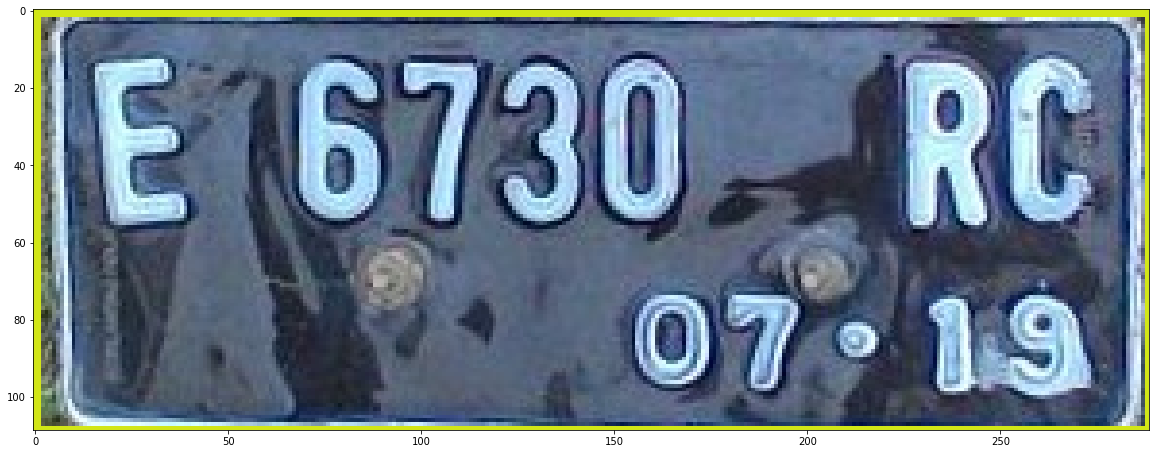

Before Threshold	=  
After Threshold		=  ; 6730 RC
LAL)



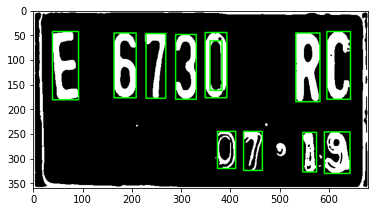

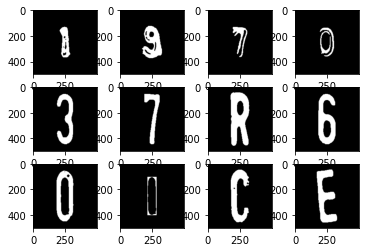

In [11]:
plt.figure(figsize=(20,10))

img = cv2.imread('img_test/15.jpg')
# img = cv2.resize(img, (680, 360))
rows = img.shape[0]
cols = img.shape[1]
cvNet.setInput(cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False))
cvOut = cvNet.forward()
crop_img = []

for detection in cvOut[0,0,:,:]:
    score = float(detection[2])
    if score > 0.3: #and ((detection[5] - detection[3] <= .6) or (detection[6] - detection[4] <= .6)):
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        if left < 0: left = 0
        if top < 0: top = 0
        if right < 0: right = 0
        if bottom < 0: bottom = 0
        crop_img.append(img[int(top):int(bottom), int(left):int(right)])
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (23, 230, 210), thickness=2)     

for i in range(0, len(crop_img)):
    crop_img[i] = cv2.cvtColor(crop_img[i], cv2.COLOR_BGR2RGB)
    plt.imshow(crop_img[i])
    plt.show()
    print("Before Threshold\t= ", pytesseract.image_to_string(crop_img[i][1], lang="engeng", config=tesseract_conf))
    
    crop_img[i] = cv2.resize(crop_img[i], (680, 360))
    crop_img[i] = cv2.cvtColor(crop_img[i], cv2.COLOR_RGB2GRAY)
    crop_img[i] = cv2.GaussianBlur(crop_img[i], (5,5), 0)
    crop_img[i] = cv2.medianBlur(crop_img[i], 3)
    crop_img[i] = cv2.threshold(crop_img[i], 175, 255, cv2.THRESH_BINARY)
    
    print("After Threshold\t\t= ", pytesseract.image_to_string(crop_img[i][1], lang="engeng", config=tesseract_conf))
    
    contours, _= cv2.findContours(crop_img[i][1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    
    for ix, c in enumerate(contours):
        contours_poly[ix] = cv2.approxPolyDP(c, 3, True)
        boundRect[ix] = cv2.boundingRect(contours_poly[ix])
    
    crop_img[i] = cv2.cvtColor(crop_img[i][1], cv2.COLOR_GRAY2BGR)
    letter = []
    
    # Draw bonding rects 
    for iz in range(len(contours)):
        top = int(boundRect[iz][1])                
        bottom = int(boundRect[iz][1]+boundRect[iz][3])            
        left = int(boundRect[iz][0])                
        right = int(boundRect[iz][0]+boundRect[iz][2])
        
        if bottom - top >= 70 and right - left >= 15 and bottom - top <= 150 and right - left <= 70:            
            cropped_letter = crop_img[i].copy()            
            letter.append(cropped_letter[top:bottom, left:right])     
            cv2.rectangle(crop_img[i], (left, top), (right, bottom), (0, 255, 0), 2)
        
    plt.imshow(crop_img[i], cmap='gray')
    plt.show()
    
    for index in range(len(letter)):   
        frame = np.zeros((500, 500, 3), dtype="uint8")
        alphabet = letter[index]
        alphabet = cv2.resize(alphabet, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
        h, w = alphabet.shape[:-1]
        
        # compute xoff and yoff for placement of upper left corner of resized image   
        yoff = round((500-h)/2)
        xoff = round((500-w)/2)

        # use numpy indexing to place the resized image in the center of background image
        result = frame.copy()
        result[yoff:yoff+h, xoff:xoff+w] = alphabet
        # print("Each Letter\t\t= ", pytesseract.image_to_string(result, lang="engeng", config=tesseract_conf))
        plt.subplot(int(np.ceil(len(letter)/4)), 4, index+1)
        plt.imshow(result, cmap='gray')
    
    plt.show()
    